In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

## Lendo o dataset das organizações intergovernamentais
https://correlatesofwar.org/data-sets/igos/ - IGO_igounit_v3.zip

In [40]:
df = pd.read_csv("igo_year_formatv3.csv", delimiter="	")

In [41]:
# Usando apenas os anos 2012-2014
years = (2012, 2013, 2014)
wanted_years = df.loc[df.year.isin(years)]

In [42]:
wanted_years.isnull().sum()

ioname                0
orgname               0
year                  0
afghanistan           0
albania               0
                   ... 
sourcesandnotes    1003
imputed               0
political             0
social                0
economic              0
Length: 235, dtype: int64

In [43]:
wanted_years.shape

(1003, 235)

In [44]:
country_columns = wanted_years.columns[3:220]
country_columns

Index(['afghanistan', 'albania', 'algeria', 'andorra', 'angola',
       'antiguabarbuda', 'argentina', 'armenia', 'australia', 'austria',
       ...
       'vietnam', 'wgermany', 'wsamoa', 'wurtenburg', 'yemen',
       'yugoslaviaserb', 'zaire', 'zambia', 'zanzibar', 'zimbabwe'],
      dtype='object', length=217)

## Problema:

Os dois datasets usados tem nomes diferentes para mesmos países, e até mesmo tem países que existem em um e não no outro.

Solução: Pegamos um .txt com os nomes de todos os países do World happines report, vamos converter a notação do nome para os dois datasets ficarem igual e vamos pegar os países contidos nos dois.

In [45]:
# Extraído do happiness report de 2015 - Simplesmente um arquivo de texto com os nomes de todos os países considerados.
with open("happiness_countries.txt", 'r') as f:
    countrys = f.readlines()

notacao_diff = {
    "unitedstates": "usa",
    "unitedkingdom": "uk",
    "centralafricanrepublic": "car",
    "southkorea": "sokorea",
    "czechrepublic": "czechrep",
    "southafrica": "soafrica",
    "dominicanrepublic": "domrepublic",
    "macedonia": "fyromacedonia",
    "unitedarabemirates": "uae",
}

countrys = set(map(lambda x: x.lower().replace("\n", "").replace(" ", ""), countrys))


set_not_in_hr = set()
for country in country_columns:
    country = country.lower().replace("\n", "").replace(" ", "")
    # Pegamos os países que não existem no happiness report.
    if not country in countrys and not country in notacao_diff.values():
        set_not_in_hr.add(country)
    

# Pega apenas a intersecção.
set_country_columns = set(country_columns)
set_country_columns = set_country_columns - set_not_in_hr

In [46]:
# Agora montamos um Dicionário com todas as combinações (País1, País2, numero IGOS em comum)
intersecs = {}

for country_1 in tqdm(set_country_columns):
    for country_2 in set_country_columns:
        if country_1 != country_2:
            country_1_present = wanted_years[country_1]
            country_2_present = wanted_years[country_2]
            # Quando o valor é 1, o país é valido e está presente na IGO.
            n_intersecs = len(wanted_years.loc[(country_1_present == 1.0) & (country_2_present == 1.0)])
            intersecs[(country_1, country_2)] = n_intersecs
                

100%|██████████| 140/140 [00:10<00:00, 13.87it/s]


### Checkpoint - Ler/Gravar o resultado anterior para construir a rede.

In [ ]:
import pickle

with open("intersecs.pickle", 'wb') as f:
    pickle.dump(intersecs, f)
# with open("intersecs.pickle", 'rb') as f:
#     intersecs = pickle.load(f)

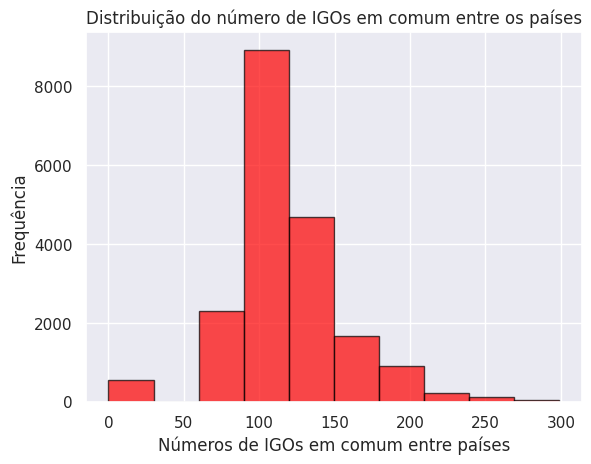

In [47]:
import matplotlib.pyplot as plt

intersecs_values = list(intersecs.values())
plt.hist(intersecs_values, color='red', alpha=0.7, edgecolor='black')
plt.xlabel('Números de IGOs em comum entre países')
plt.ylabel("Frequência")
plt.title("Distribuição do número de IGOs em comum entre os países")
plt.show()

In [48]:
inter_df = pd.DataFrame(intersecs_values, columns=['N intersecs'])
inter_df['N intersecs'].describe()

count    19460.000000
mean       117.651593
std         37.309994
min          0.000000
25%         97.000000
50%        112.000000
75%        134.000000
max        299.000000
Name: N intersecs, dtype: float64

In [49]:
threshold = inter_df['N intersecs'].mode()[0]
threshold

103

In [50]:
import netpixi
from netpixi.integration.gt import *
from regression.integration.gt import *

## Montando a rede

In [51]:
g = Graph(directed=False)

for countrys, n_intersecs in intersecs.items():
    if n_intersecs > threshold:
        if not g.has_vertex(countrys[0]):
            v1 = g.add_vertex(countrys[0])
        if not g.has_vertex(countrys[1]):
            v2 = g.add_vertex(countrys[1])
            
        if not g.has_edge(countrys[0], countrys[1]):
            g.add_edge(countrys[0], countrys[1])

PATH_REDE = 'IGOS.net.gz'
gt_save(g, PATH_REDE)

## Estatísticas

In [52]:
n = g.num_vertices()
m = g.num_edges()

print(f"Número de arestas: {m}")
print(f"Número de vértices: {n}")

Número de arestas: 6120
Número de vértices: 138


In [53]:
max_edges = n * (n - 1) // 2
print(f"Número máximo de arestas: {max_edges}")
d = m / max_edges
print(f"Densidade: {d}")

Número máximo de arestas: 9453
Densidade: 0.6474135195176135


In [54]:
data = gt_data(g)

degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())
    
data['degree'] = degrees

In [55]:
data['degree'].describe()

count    138.000000
mean      88.695652
std       31.510075
min        4.000000
25%       72.000000
50%       98.000000
75%      112.750000
max      127.000000
Name: degree, dtype: float64

<AxesSubplot: xlabel='degree', ylabel='Count'>

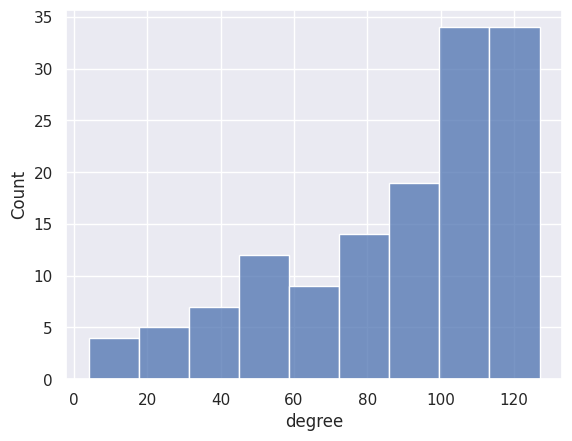

In [56]:
sns.histplot(data['degree'])

In [57]:
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
gt_save(g, 'rede_sfdp.net.gz')
r = netpixi.render('rede_sfdp.net.gz', infinite=True);

In [58]:
# Para poder visualizar o nome dos países (Ajuda a ver quais são os países no centro/periferia).
r.vertex_set_key('id')

## Algoritmo para cálcular o coreness contínuo

Escala o tamanho dos vértices do grafo com o valor do coreness.

In [59]:
import cpnet

from graph_tool import spectral

In [60]:
matrix = spectral.adjacency(g)

# Além de cpnet.Rombach, há outras
# opções de algoritmos contínuos:
# cpnet.MINRES
# cpnet.Rossa

algorithm = cpnet.Rombach()
algorithm.detect(matrix)
c = algorithm.get_coreness()

# Depois do código acima, c é um dicionário
# em que as chaves são índices de vértices e
# valores são os atribuídos pelo algoritmo.

g.add_vp('coreness')
for i, coreness in c.items():
    v = g.get_vertex_by_index(i)
    v['coreness'] = float(coreness)

# Vamos usar coreness como referência para
# o tamanho dos vértices. Estabelecemos 10
# como o menor tamanho possível e 40 como
# o maior tamanho possível. Como o coreness
# está entre 0 e 1, a conta é bem simples.

for v in g.all_vertices():
    r.vertex(v['id'], size=(10 + 40 * v['coreness']))

# Quando a execução desta célula terminar,
# veja como ficou a visualização acima.

## Dataframe com os coreness para cada um dos países.

In [66]:
data = gt_data(g)
data.head()

,coreness
id,
srilanka,0.129545
morocco,0.910714
jordan,0.175000
kenya,0.225000
thailand,0.211364
